# Week 10: Convolutional Layers in PyTorch

In [58]:
import sklearn.datasets
import sklearn.model_selection
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn
import torch.nn.functional
import skorch

In [59]:
import importlib
import week10_funcs as w10f
importlib.reload(w10f)

<module 'week10_funcs' from '/home/curt/OneDrive/Faculty/2023-fall/ee5830/week10_funcs.py'>

## MNIST setup

In [60]:
bunch_mnist = sklearn.datasets.fetch_openml(
    data_id=554,
    as_frame=False
)

/home/curt/mambaforge/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [61]:
bunch_mnist.data.shape

(70000, 784)

In [62]:
bunch_mnist.target.shape

(70000,)

In [63]:
mnist_X = bunch_mnist.data.astype('float32')
mnist_y = bunch_mnist.target.astype('int64')  # why did they recommend int64?

In [64]:
mnist_X_cnn = mnist_X.reshape(-1, 1, 28, 28)

In [65]:
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = sklearn.model_selection.train_test_split(
    mnist_X_cnn,
    mnist_y,
    test_size=0.3,
    random_state=7
)

In [66]:
mnist_X_train.shape, mnist_X_train.dtype, mnist_y_train.shape, mnist_y_train.dtype

((49000, 1, 28, 28), dtype('float32'), (49000,), dtype('int64'))

## MNIST using Convolutional network

In [67]:
torch.manual_seed(7)

cnn = skorch.NeuralNetClassifier(
    w10f.ClayClassifierModule,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
)

In [68]:
mnist_n_outputs = len(np.unique(mnist_y))

cnn.module__n_input_channels = 1  # only one channel in MNIST
cnn.module__n_output_probs = mnist_n_outputs
cnn.module__input_img_height = mnist_X_train.shape[-1]

In [69]:
cnn.fit(mnist_X_train, mnist_y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9251       0.9639        0.1447  7.2985
      2        0.1147       0.9798        0.0740  7.8401
      3        0.0898       0.9790        0.0775  6.8086
      4        0.0738       0.9839        0.0583  6.7103
      5        0.0674       0.9847        0.0553  6.9185
      6        0.0588       0.9861        0.0532  6.7461
      7        0.0603       0.9855        0.0515  6.7290
      8        0.0577       0.9862        0.0510  6.6963
      9        0.0516       0.9880        0.0472  6.7866
     10        0.0489       0.9846        0.0547  6.7585


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClayClassifierModule(
    (conv_network): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(6, 6), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
      (3): Dropout(p=0.5, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (dense_network): ModuleList(
      (0): Linear(in_features=576, out_features=100, bias=True)
      (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    )
    (output): Linear(in_features=100, out_features=1, bias=True)
  ),
)

### Which ones were mispredicted?

In [70]:
mnist_y_pred = cnn.predict(mnist_X_test)  # , mnist_y_test)

In [71]:
mnist_y_test

array([2, 2, 9, ..., 4, 9, 5])

In [72]:
np.where((mnist_y_pred - mnist_y_test) != 0)

(array([    6,    47,    75,   141,   170,   290,   390,   418,   606,
          750,   790,   835,   846,   898,   944,  1075,  1080,  1122,
         1146,  1262,  1316,  1414,  1495,  1513,  1564,  1651,  1662,
         1706,  1828,  1883,  1993,  2022,  2057,  2183,  2269,  2271,
         2274,  2288,  2341,  2385,  2469,  2513,  2747,  2884,  2894,
         2980,  3027,  3042,  3050,  3089,  3130,  3254,  3267,  3282,
         3325,  3477,  3617,  3721,  3850,  4097,  4192,  4238,  4339,
         4368,  4675,  4728,  4732,  4815,  4960,  5006,  5013,  5053,
         5225,  5229,  5284,  5306,  5359,  5637,  5663,  5668,  5823,
         5895,  5947,  6024,  6035,  6037,  6295,  6309,  6326,  6334,
         6349,  6370,  6459,  6486,  6625,  6704,  6744,  6828,  6834,
         6842,  7117,  7150,  7188,  7587,  7603,  7608,  7609,  7758,
         7807,  8016,  8163,  8168,  8176,  8194,  8237,  8295,  8297,
         8396,  8397,  8550,  8595,  8624,  8653,  8663,  8667,  8714,
      

In [16]:
for idx in np.where((mnist_y_pred != mnist_y_test))[0]:
    print(f"y_pred: {mnist_y_pred[idx]}, y_true: {mnist_y_test[idx]}")

y_pred: 7, y_true: 2
y_pred: 3, y_true: 5
y_pred: 7, y_true: 1
y_pred: 3, y_true: 7
y_pred: 8, y_true: 6
y_pred: 2, y_true: 7
y_pred: 8, y_true: 7
y_pred: 2, y_true: 8
y_pred: 9, y_true: 8
y_pred: 3, y_true: 2
y_pred: 2, y_true: 8
y_pred: 4, y_true: 9
y_pred: 7, y_true: 1
y_pred: 7, y_true: 1
y_pred: 8, y_true: 0
y_pred: 4, y_true: 1
y_pred: 0, y_true: 6
y_pred: 4, y_true: 1
y_pred: 9, y_true: 8
y_pred: 2, y_true: 1
y_pred: 7, y_true: 9
y_pred: 9, y_true: 4
y_pred: 0, y_true: 2
y_pred: 7, y_true: 9
y_pred: 2, y_true: 3
y_pred: 7, y_true: 9
y_pred: 2, y_true: 8
y_pred: 6, y_true: 5
y_pred: 0, y_true: 2
y_pred: 0, y_true: 9
y_pred: 6, y_true: 0
y_pred: 7, y_true: 2
y_pred: 7, y_true: 3
y_pred: 8, y_true: 5
y_pred: 3, y_true: 9
y_pred: 8, y_true: 9
y_pred: 4, y_true: 1
y_pred: 4, y_true: 7
y_pred: 3, y_true: 1
y_pred: 4, y_true: 7
y_pred: 1, y_true: 9
y_pred: 9, y_true: 4
y_pred: 8, y_true: 1
y_pred: 4, y_true: 9
y_pred: 4, y_true: 9
y_pred: 9, y_true: 8
y_pred: 8, y_true: 5
y_pred: 7, y_

### Accessing convolutional layers

In [73]:
%matplotlib inline
from torchvision import utils
import matplotlib.pyplot as plt

In [74]:
cnn.module_.conv_network[0].weight.shape

torch.Size([32, 1, 6, 6])

In [75]:
l0_n, l0_c, l0_w, l0_h = cnn.module_.conv_network[0].weight.shape

In [77]:
# this does nothing, FYI, since all Conv2D weights are 4D tensors now.

cnn.module_.conv_network[0].weight.clone()[:,0,:,:].unsqueeze(dim=1).shape

torch.Size([32, 1, 6, 6])

In [78]:
feature_grid = utils.make_grid(
    tensor=cnn.module_.conv_network[0].weight.clone(),
    nrow=6,
    normalize=True,
    padding=1
)

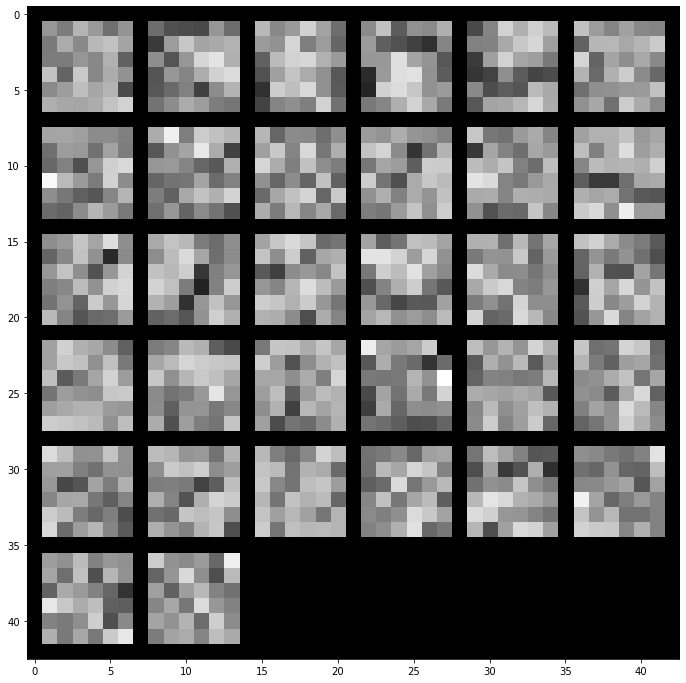

In [79]:
fig = plt.figure(figsize=(6*2, 6*2))
ax = fig.gca()
ax.set_aspect('auto')
ax.imshow(feature_grid.numpy().transpose(1, 2, 0))